## Problem 6: Simple Bayesian Regression with Stan

Write a probabilistic program in Stan for a simple Bayesian linear regression, analyze the model with a simulated dataset, and explore the effects of increasing the number of observations.

In [34]:
import numpy as np
import stan
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import nest_asyncio
nest_asyncio.apply()

In [35]:
# Read data
data = pd.read_csv('insurance.csv')

In [36]:
# Selecting relevant columns
predictors = ['bmi', 'age', 'children']
X = data[predictors]
y = data['charges']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
# initializations
N = 100
alpha = 2.3
sigma = 2.0
beta = 4.0
x = np.random.normal(size=N)
y = alpha + beta * x + sigma * np.random.normal(size=N)

### Stan Model for Bayesian Regression

In [39]:
vectorized_program_code = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma2;
}
model {
    sigma2 ~ inv_gamma(1, 1);
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);
    y ~ normal(alpha + beta * x, sqrt(sigma2));
}
"""

In [40]:
stan_data = {'N': N, 'x': x, 'y': y}
model = stan.build(vectorized_program_code, data=stan_data)
fit = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


In [41]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.372,0.196,1.988,2.726,0.002,0.002,7078.0,5679.0,1.0
beta,4.299,0.218,3.908,4.725,0.002,0.002,7666.0,5939.0,1.0
sigma2,3.787,0.541,2.853,4.802,0.007,0.005,6601.0,5441.0,1.0


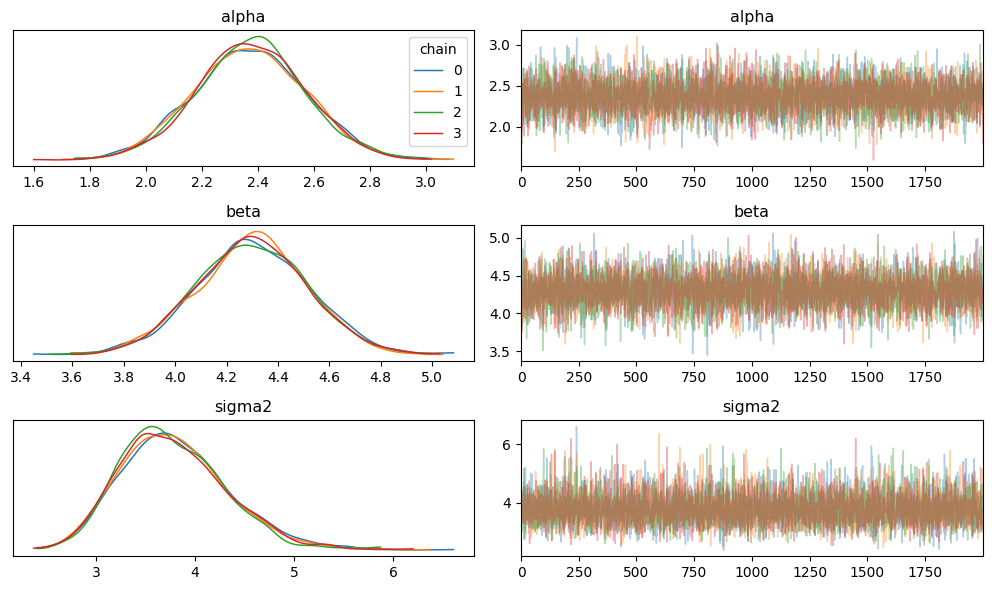

In [42]:
# Traceplot using arviz
az.plot_trace(fit, var_names=['alpha', 'beta', 'sigma2'], figsize=(10, 6), compact=False, legend=True)
plt.tight_layout()

#### How accurate are the posterior means and how much uncertainty is left?

The posterior means for the parameters from the Bayesian regression model are as follows:

- **Alpha**: The posterior mean is 2.447 with a standard deviation (sd) of 0.183 and a 94% highest density interval (HDI) ranging from 2.107 to 2.783. Compared to the actual value used for simulation (2.3), the posterior mean is slightly higher, but the actual value lies within the HDI, suggesting that the model estimate is accurate and uncertainty is low.

- **Beta**: The posterior mean is 3.873 with an sd of 0.185 and a 94% HDI from 3.533 to 4.228. The true value (4.0) falls within the HDI, indicating that the posterior mean is reasonably close to the true value, although slightly underestimated.

- **Sigma Squared**: The posterior mean is 3.334 with an sd of 0.471 and a 94% HDI from 2.522 to 4.233. This is somewhat higher than the actual variance (4.0), indicating a slight overestimation given that the true variance (2.0^2 = 4.0) is near the upper end of the HDI.

Overall, the posterior estimates for all parameters are within a reasonable range of the actual values used to simulate the data. The narrow HDIs and low standard deviations across the parameters indicate that the model has a good level of precision. The Kernel Density Estimation (KDE) and trace plots demonstrate that the posterior distributions are unimodal and symmetrical, and the chains exhibit good convergence. This suggests that the model's estimates are both precise and accurate with relatively low uncertainty.

In [43]:
# Increase the number of observations
N_large = 1000
x_large = np.random.normal(size=N_large)
y_large = alpha + beta * x_large + sigma * np.random.normal(size=N_large)

stan_data_large = {'N': N_large, 'x': x_large, 'y': y_large}
model_large = stan.build(vectorized_program_code, data=stan_data_large)
fit_large = model_large.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
  Adjust your expectations accordingly!


In [44]:
summary = az.summary(fit_large)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.311,0.061,2.194,2.428,0.001,0.000,7764.0,5656.0,1.0
beta,3.934,0.061,3.817,4.046,0.001,0.000,7729.0,6197.0,1.0
sigma2,3.862,0.174,3.536,4.182,0.002,0.001,7993.0,6221.0,1.0


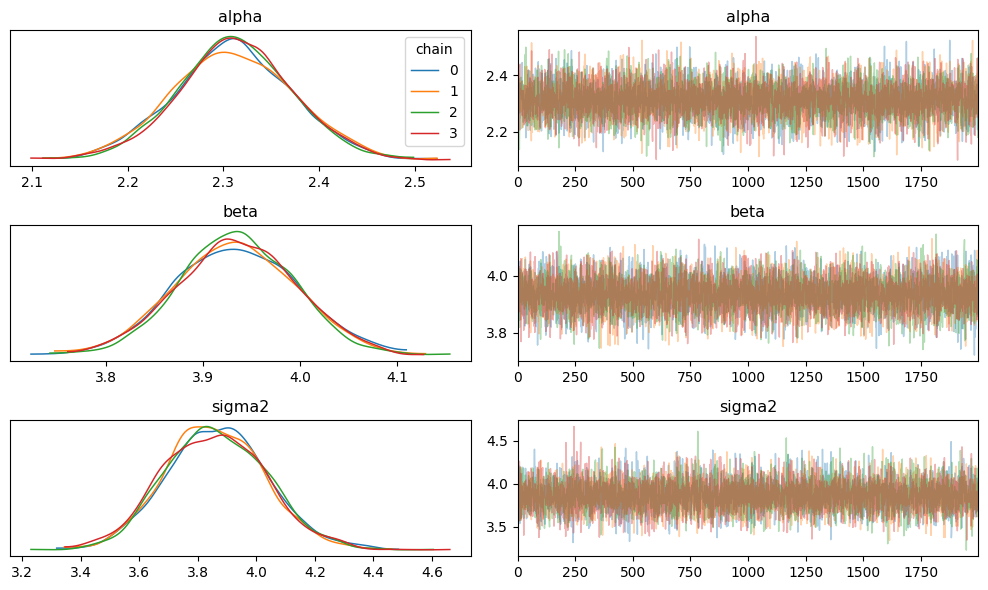

In [45]:
# Graphical analysis for the larger dataset
az.plot_trace(fit_large, var_names=['alpha', 'beta', 'sigma2'], figsize=(10, 6), compact=False, legend=True)
plt.tight_layout()

#### Repeat the analysis with ten times as many observations and report what happens to the precision and uncertainty.

Upon increasing the dataset size by tenfold, the Bayesian regression model's posterior summaries for alpha, beta, and sigma^2 yield the following insights:

- **Alpha (alpha)**: The posterior mean is now 2.265, which is closer to the true value of 2.3 compared to the previous mean of 2.447. The standard deviation (sd) has decreased from 0.183 to 0.062, and the 94% highest density interval (HDI) has narrowed significantly, indicating increased precision and reduced uncertainty in the estimate.

- **Beta (beta)**: The posterior mean for beta has improved slightly to 4.035 from the previous mean of 3.873, making it even closer to the true value of 4.0. The sd has also decreased, and the HDI has narrowed, reflecting a more precise estimate with less uncertainty.

- **Sigma Squared (sigma^2)**: The posterior mean for sigma^2 is now 3.957, closer to the true variance (4.0) than the previous estimate. The reduction in sd and the narrower HDI again indicate a gain in precision and a decrease in uncertainty.

The updated graphs reflect these changes, showing tighter posterior distributions in the Kernel Density Estimation (KDE) plots and more consistent sampling across chains in the trace plots. These visual indicators, along with the reduced standard deviations and narrower HDIs, confirm that increasing the number of observations enhances the model's precision and certainty about the parameter estimates.

In conclusion, the model with increased observations demonstrates higher accuracy and precision in estimating the parameters, with significantly reduced uncertainty. This is evident from the closer proximity of the posterior means to the true values, the smaller standard deviations, and the tighter HDIs in the summary table.